In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def plot_series(time,series,start=0,end=None,format='-'):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O sunspots.csv

--2020-07-07 13:08:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘sunspots.csv’

sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2020-07-07 13:08:36 (44.6 MB/s) - ‘sunspots.csv’ saved [70827/70827]



In [4]:
import os
os.listdir()

['.config', 'sunspots.csv', 'sample_data']

In [5]:
mycsv = 'sunspots.csv'
import csv

In [6]:
sunspots = [] ; time_step = [];
with open(mycsv,'r') as f:
  reader = csv.reader(f,delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))


In [7]:
series = np.array(sunspots)
time = np.array(time_step)

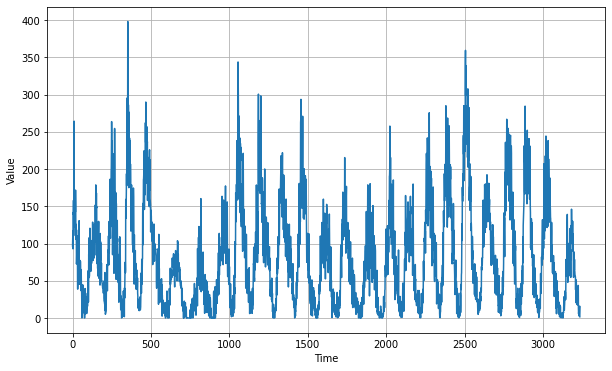

In [8]:
plt.figure(figsize=(10,6))
plot_series(time,series)

In [9]:
split_time = 3000 
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model,series,window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(batch_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [12]:
window_size = 30 
batch_size = 32 
shuffle_buffer_size = 100

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train,window_size=64,batch_size=256,shuffle_buffer=100)

In [14]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [15]:
model_lstm = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(32,kernel_size=5,padding='causal',activation='relu',input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(32,activation='relu'),
                                    tf.keras.layers.Dense(16,activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
                                    ])

In [16]:
model_rnn = tf.keras.models.Sequential([
                                         tf.keras.layers.Conv1D(32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
                                         tf.keras.layers.SimpleRNN(64,return_sequences='True'),
                                         tf.keras.layers.SimpleRNN(64,return_sequences='True'),
                                         tf.keras.layers.Dense(32,activation='relu'),
                                         tf.keras.layers.Dense(16,activation='relu'),
                                         tf.keras.layers.Dense(1),
                                         tf.keras.layers.Lambda(lambda x: x*400)
])

In [17]:
model_gru = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv1D(32,kernel_size=5,strides=1,padding='causal',input_shape=[None,1],activation='relu'),
                                        tf.keras.layers.GRU(64,activation='relu',return_sequences=True),
                                        tf.keras.layers.GRU(64,return_sequences=True,activation='relu'),
                                        tf.keras.layers.Dense(32,activation='relu'),
                                        tf.keras.layers.Dense(16,activation='relu'),
                                        tf.keras.layers.Dense(1),
                                        tf.keras.layers.Lambda(lambda x:x*400)
])

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10*(epoch/20))

In [19]:
optimizer_0 = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

In [20]:
model_lstm.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer_0,metrics=['mae'])

In [21]:
model_rnn.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer_0,metrics=['mae'])

In [22]:
model_gru.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer_0,metrics=['mae'])

In [23]:
history_lstm = model_lstm.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 3s 289ms/step - loss: 64.0832 - mae: 64.5807 - lr: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 3s 287ms/step - loss: 64.0167 - mae: 64.5142 - lr: 5.0000e-09
Epoch 3/100
12/12 [==============================] - 3s 287ms/step - loss: 63.6348 - mae: 64.1322 - lr: 1.0000e-08
Epoch 4/100
12/12 [==============================] - 3s 284ms/step - loss: 62.8099 - mae: 63.3074 - lr: 1.5000e-08
Epoch 5/100
12/12 [==============================] - 3s 289ms/step - loss: 61.3879 - mae: 61.8856 - lr: 2.0000e-08
Epoch 6/100
12/12 [==============================] - 3s 288ms/step - loss: 59.1426 - mae: 59.6403 - lr: 2.5000e-08
Epoch 7/100
12/12 [==============================] - 3s 282ms/step - loss: 56.3719 - mae: 56.8693 - lr: 3.0000e-08
Epoch 8/100
12/12 [==============================] - 3s 284ms/step - loss: 53.5839 - mae: 54.0810 - lr: 3.5000e-08
Epoch 9/100
12/12 [==============================] - 3s 285ms/step - loss: 51.15

In [24]:
history_rnn = model_rnn.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 1s 88ms/step - loss: 264.2746 - mae: 264.7740 - lr: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 1s 90ms/step - loss: 260.9269 - mae: 261.4262 - lr: 5.0000e-09
Epoch 3/100
12/12 [==============================] - 1s 90ms/step - loss: 243.1396 - mae: 243.6391 - lr: 1.0000e-08
Epoch 4/100
12/12 [==============================] - 1s 88ms/step - loss: 210.9637 - mae: 211.4631 - lr: 1.5000e-08
Epoch 5/100
12/12 [==============================] - 1s 89ms/step - loss: 174.3977 - mae: 174.8972 - lr: 2.0000e-08
Epoch 6/100
12/12 [==============================] - 1s 91ms/step - loss: 143.5145 - mae: 144.0136 - lr: 2.5000e-08
Epoch 7/100
12/12 [==============================] - 1s 92ms/step - loss: 120.9642 - mae: 121.4629 - lr: 3.0000e-08
Epoch 8/100
12/12 [==============================] - 1s 90ms/step - loss: 106.6765 - mae: 107.1746 - lr: 3.5000e-08
Epoch 9/100
12/12 [==============================] - 1s 90ms/step - loss

In [25]:
history_gru = model_gru.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 3s 236ms/step - loss: 430.0468 - mae: 430.5457 - lr: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 3s 234ms/step - loss: 422.0179 - mae: 422.5167 - lr: 5.0000e-09
Epoch 3/100
12/12 [==============================] - 3s 237ms/step - loss: 376.8368 - mae: 377.3356 - lr: 1.0000e-08
Epoch 4/100
12/12 [==============================] - 3s 236ms/step - loss: 283.9024 - mae: 284.4013 - lr: 1.5000e-08
Epoch 5/100
12/12 [==============================] - 3s 230ms/step - loss: 193.5201 - mae: 194.0193 - lr: 2.0000e-08
Epoch 6/100
12/12 [==============================] - 3s 234ms/step - loss: 156.2610 - mae: 156.7604 - lr: 2.5000e-08
Epoch 7/100
12/12 [==============================] - 3s 231ms/step - loss: 131.6966 - mae: 132.1956 - lr: 3.0000e-08
Epoch 8/100
12/12 [==============================] - 3s 233ms/step - loss: 115.0209 - mae: 115.5200 - lr: 3.5000e-08
Epoch 9/100
12/12 [==============================] - 3s 235ms/st

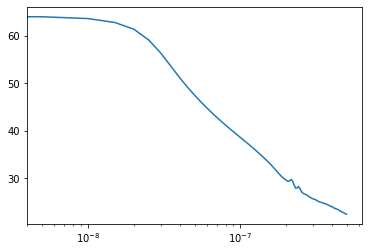

In [26]:
plt.semilogx(history_lstm.history['lr'],history_lstm.history['loss'])


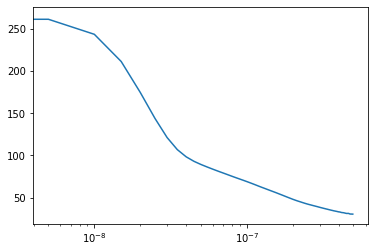

In [27]:
plt.semilogx(history_rnn.history['lr'],history_rnn.history['loss'])


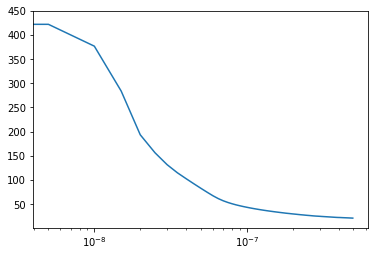

In [28]:
plt.semilogx(history_gru.history['lr'],history_gru.history['loss'])

It Seems that the loss reduces linearly with increase in learning rate for LSTM Model

While for the SimpleRNN and GRU the loss reduces exponentialy . 
The curve in the GRU seems much more smoother than SimpleRNN . 
Simply we can consider as the smooth ness range lies between 1e-8 and 1e-7 so any value in between them will be suitable for a generalized model .

While talking about LSTM initially the loss is not decreasing with increase in learning rate after 1e-8 it starts dropping linearly so it is kinda optimistic for us but not much .
We must also keep in mind that SimpleRNN and GRU starts at a higher loss . while LSTM starts at much lower loss .

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


In [31]:
dataset = windowed_dataset(x_train,window_size=64,batch_size=256,shuffle_buffer=100)


In [32]:
model_lstm = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(32,activation='relu'),
                                    tf.keras.layers.Dense(16,activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

In [33]:
model_rnn = tf.keras.models.Sequential([
                                         tf.keras.layers.Conv1D(32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
                                         tf.keras.layers.SimpleRNN(64,return_sequences='True'),
                                         tf.keras.layers.SimpleRNN(64,return_sequences='True'),
                                         tf.keras.layers.Dense(32,activation='relu'),
                                         tf.keras.layers.Dense(16,activation='relu'),
                                         tf.keras.layers.Dense(1),
                                         tf.keras.layers.Lambda(lambda x: x*400)
])

In [34]:
model_gru = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv1D(32,kernel_size=5,strides=1,padding='causal',input_shape=[None,1],activation='relu'),
                                        tf.keras.layers.GRU(64,activation='relu',return_sequences=True),
                                        tf.keras.layers.GRU(64,return_sequences=True,activation='relu'),
                                        tf.keras.layers.Dense(32,activation='relu'),
                                        tf.keras.layers.Dense(16,activation='relu'),
                                        tf.keras.layers.Dense(1),
                                        tf.keras.layers.Lambda(lambda x:x*400)
])

In [35]:
model_lstm.compile(loss=tf.keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['mae'])

In [36]:
model_rnn.compile(loss=tf.keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['mae'])

In [37]:
model_gru.compile(loss=tf.keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['mae'])

In [38]:
history_lstm = model_lstm.fit(dataset,epochs=100)

Epoch 1/100
12/12 [==============================] - 3s 286ms/step - loss: 42.6877 - mae: 43.1847
Epoch 2/100
12/12 [==============================] - 3s 286ms/step - loss: 36.8564 - mae: 37.3527
Epoch 3/100
12/12 [==============================] - 3s 286ms/step - loss: 29.9541 - mae: 30.4494
Epoch 4/100
12/12 [==============================] - 3s 287ms/step - loss: 27.5876 - mae: 28.0826
Epoch 5/100
12/12 [==============================] - 3s 290ms/step - loss: 24.4607 - mae: 24.9556
Epoch 6/100
12/12 [==============================] - 3s 287ms/step - loss: 22.9618 - mae: 23.4561
Epoch 7/100
12/12 [==============================] - 3s 285ms/step - loss: 22.6393 - mae: 23.1331
Epoch 8/100
12/12 [==============================] - 3s 286ms/step - loss: 22.7553 - mae: 23.2496
Epoch 9/100
12/12 [==============================] - 3s 286ms/step - loss: 22.8282 - mae: 23.3228
Epoch 10/100
12/12 [==============================] - 3s 288ms/step - loss: 21.6164 - mae: 22.1105
Epoch 11/100
12/12 

In [39]:
history_rnn = model_rnn.fit(dataset,epochs=100)

Epoch 1/100
12/12 [==============================] - 1s 92ms/step - loss: 87.9755 - mae: 88.4742
Epoch 2/100
12/12 [==============================] - 1s 91ms/step - loss: 41.9892 - mae: 42.4857
Epoch 3/100
12/12 [==============================] - 1s 91ms/step - loss: 42.5626 - mae: 43.0604
Epoch 4/100
12/12 [==============================] - 1s 92ms/step - loss: 37.3082 - mae: 37.8045
Epoch 5/100
12/12 [==============================] - 1s 95ms/step - loss: 37.8524 - mae: 38.3487
Epoch 6/100
12/12 [==============================] - 1s 92ms/step - loss: 33.3787 - mae: 33.8748
Epoch 7/100
12/12 [==============================] - 1s 91ms/step - loss: 34.2586 - mae: 34.7545
Epoch 8/100
12/12 [==============================] - 1s 92ms/step - loss: 34.0448 - mae: 34.5412
Epoch 9/100
12/12 [==============================] - 1s 92ms/step - loss: 36.1183 - mae: 36.6153
Epoch 10/100
12/12 [==============================] - 1s 90ms/step - loss: 34.3246 - mae: 34.8207
Epoch 11/100
12/12 [=========

In [40]:
history_gru = model_gru.fit(dataset,epochs=100)

Epoch 1/100
12/12 [==============================] - 3s 236ms/step - loss: 116.8174 - mae: 117.3156
Epoch 2/100
12/12 [==============================] - 3s 233ms/step - loss: 27.0184 - mae: 27.5140
Epoch 3/100
12/12 [==============================] - 3s 233ms/step - loss: 20.5432 - mae: 21.0370
Epoch 4/100
12/12 [==============================] - 3s 236ms/step - loss: 20.8302 - mae: 21.3238
Epoch 5/100
12/12 [==============================] - 3s 236ms/step - loss: 18.9146 - mae: 19.4076
Epoch 6/100
12/12 [==============================] - 3s 233ms/step - loss: 18.8935 - mae: 19.3859
Epoch 7/100
12/12 [==============================] - 3s 233ms/step - loss: 18.7701 - mae: 19.2625
Epoch 8/100
12/12 [==============================] - 3s 236ms/step - loss: 18.3630 - mae: 18.8557
Epoch 9/100
12/12 [==============================] - 3s 233ms/step - loss: 18.5297 - mae: 19.0225
Epoch 10/100
12/12 [==============================] - 3s 233ms/step - loss: 18.3188 - mae: 18.8114
Epoch 11/100
12/1

In [46]:
lstm_forecast = model_forecast(model_lstm,series[...,np.newaxis],window_size=64)
rnn_forecast = model_forecast(model_rnn,series[...,np.newaxis],window_size=64) 
gru_forecast = model_forecast(model_gru,series[...,np.newaxis],window_size=64)

In [47]:
#lstm_forecast[split_time-window_size:-1,-1,0]

In [48]:
lstm_forecast = lstm_forecast[split_time-window_size:-1,-1,0]
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]
gru_forecast = gru_forecast[split_time-window_size:-1,-1,0]

In [50]:
print(len(rnn_forecast))

235


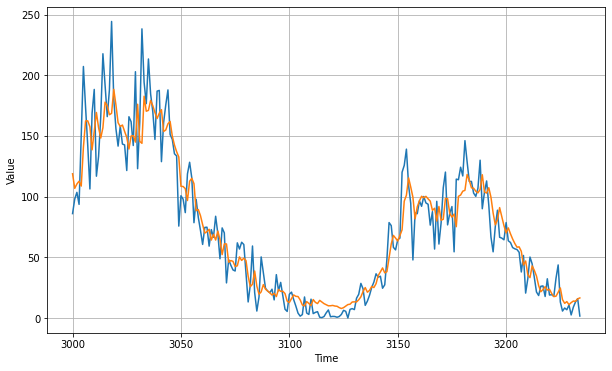

In [51]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,lstm_forecast)

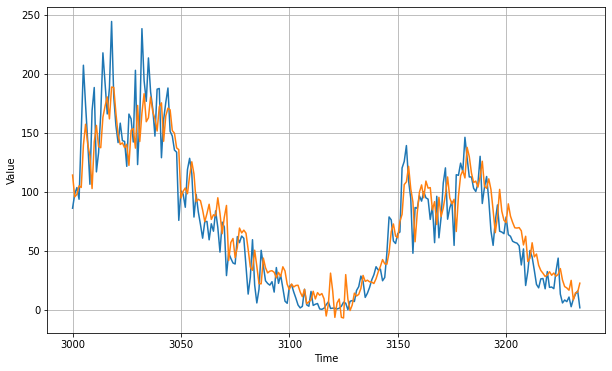

In [52]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

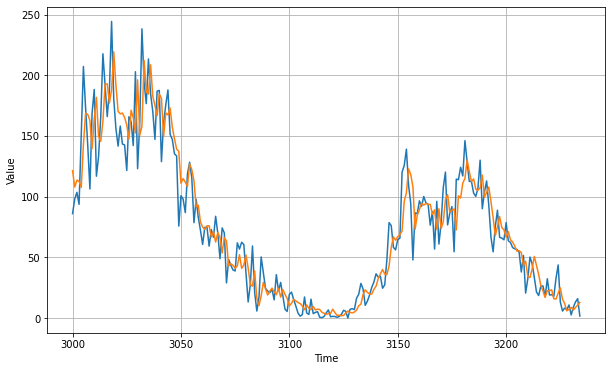

In [53]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,gru_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid,lstm_forecast).numpy()

14.132716

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

16.265112

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid,gru_forecast).numpy()

14.415506

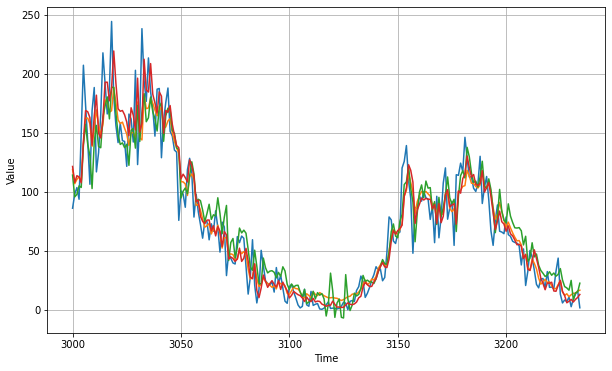

In [59]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,lstm_forecast)
plot_series(time_valid,rnn_forecast)
plot_series(time_valid,gru_forecast)

#Conclusion 
SimpleRNN have higher mae than LSTM and GRU and also shows peaks where there should'nt be any so it must be avoided on such data.
The LSTM shows lower mae than all but GRU are better in fitting the Data . 
So my conclusion is we must use GRU Since it fits better , and we must tweak more on the hyperparameter on it so that we can get less mae